# Data grab and clean up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = "Traditional v Alt.xlsx"

# Load the "Combined" sheet
df = pd.read_excel(file_path, sheet_name="Combined")

# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Implementation

                     CAGR Volatility Sharpe (rf=3%) Total Return  \
60/40 Benchmark   0.04398   0.077874       0.207038     0.385956   
50/30/20 Alt     0.055815   0.101992       0.290384     0.509642   

                Sortino (rf=3%)    Max DD DD Duration (m) DD Start DD Trough  \
60/40 Benchmark         0.29323 -0.114804               9  2021-12   2022-09   
50/30/20 Alt            0.41067 -0.140968               2  2020-01   2020-03   

                Information Ratio v 60/40  
60/40 Benchmark                       NaN  
50/30/20 Alt                     0.453979  


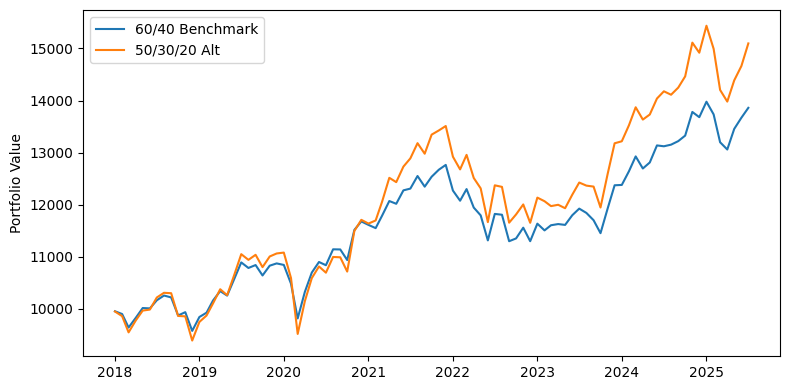

In [ ]:
#Full-period testing

#Compute periodic returns (monthly assumed; use .pct_change() for daily too)
rets = df[['Van-FTSE All-World','Agg Bond GBP','Private Equity Proxy']].pct_change().dropna()

#Define portfolio weights
w_bench = np.array([0.6, 0.4])       # 60% Equity, 40% Bond
w_alt   = np.array([0.5, 0.3, 0.2])  # 50% Equity, 30% Bond, 20% PE

#Compute portfolio returns
bench_ret = rets[['Van-FTSE All-World','Agg Bond GBP']].dot(w_bench)
alt_ret   = rets[['Van-FTSE All-World','Agg Bond GBP','Private Equity Proxy']].dot(w_alt)

ports = pd.DataFrame({
    '60/40 Benchmark': bench_ret,
    '50/30/20 Alt':    alt_ret
})

#Performance metric functions
def annualized_volatility(r, periods_per_year=12):
    return r.std() * np.sqrt(periods_per_year)

def cagr(r, periods_per_year=12):
    n = r.shape[0]
    years = n / periods_per_year
    total_ret = (1 + r).prod()
    return total_ret**(1/years) - 1

def sharpe_ratio(r, periods_per_year=12, rf=0.03):
    # rf = annual risk‑free rate; here divided into each period
    excess = r - rf/periods_per_year
    return (excess.mean() / r.std()) * np.sqrt(periods_per_year)

#def max_drawdown(r):
#     cum = (1 + r).cumprod()
#     peak = cum.cummax()
#     dd = (cum - peak) / peak
#     return dd.min()

def max_drawdown_stats(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum/peak - 1

    # depth & trough
    depth = dd.min()
    if depth == 0:
        return {'depth': 0, 'duration': 0, 'start': None, 'trough': None}

    trough = dd.idxmin()

    # peak date = date of the highest cum value up to trough
    cum_up_to_trough = cum.loc[:trough]
    start = cum_up_to_trough.idxmax()

    # duration in months (index difference)
    duration = cum.index.get_loc(trough) - cum.index.get_loc(start)

    return {
        'depth':     depth,
        'duration':  int(duration),
        'start':     start,
        'trough':    trough
    }
    
def sortino_ratio(r, periods_per_year=12, rf=0.03):
    excess = r - rf/periods_per_year
    downside_var = np.mean(np.where(excess<0, excess**2,0.0))
    downside_std = np.sqrt(downside_var)*np.sqrt(periods_per_year)
    annual_excess_r = excess.mean()*periods_per_year
    return annual_excess_r / downside_std

def information_ratio(alt_ret, bench_ret, periods_per_year=12):
    active = alt_ret - bench_ret
    active_mean = active.mean()*periods_per_year
    tracking_err = active.std()* np.sqrt(periods_per_year)
    return active_mean/ tracking_err

#Calculate and tabulate metrics
metrics = {}
for name, series in ports.items():
    stats = max_drawdown_stats(series)
    metrics[name] = {
        'CAGR':            cagr(series),
        'Volatility':      annualized_volatility(series),
        'Sharpe (rf=3%)':  sharpe_ratio(series),
        # 'Max Drawdown':    max_drawdown(series),
        'Total Return':    (1 + series).prod() - 1,
        'Sortino (rf=3%)': sortino_ratio(series),
        'Max DD':         stats['depth'],
        'DD Duration (m)': stats['duration'],
        'DD Start':       stats['start'].strftime('%Y-%m') if stats['start'] else None,
        'DD Trough':      stats['trough'].strftime('%Y-%m') if stats['trough'] else None,
        
    }
#Information Ratio for non-benchmark portfolios
metrics['50/30/20 Alt']['Information Ratio v 60/40'] = information_ratio(ports['50/30/20 Alt'],ports['60/40 Benchmark'])

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

#Plot cumulative growth
initial_investment = 10000
cum_growth = (1 + ports).cumprod()
portfolio_value = cum_growth* initial_investment
plt.figure(figsize=(8,4))
for col in portfolio_value:
    plt.plot(portfolio_value.index, portfolio_value[col], label=col)
# plt.title('Growth of $10,000 – 60/40 vs 50/30/20')
plt.ylabel('Portfolio Value')
plt.legend()
plt.tight_layout()
plt.show()

      Bench Total Return  Bench annualized_volatility  Bench Sharpe  \
Year                                                                  
2018           -0.042380                     0.067496     -1.053626   
2019            0.135325                     0.057825      1.714056   
2020            0.074134                     0.119816      0.403426   
2021            0.092943                     0.045834      1.312603   
2022           -0.114766                     0.095295     -1.543823   
2023            0.095035                     0.069969      0.905361   
2024            0.105693                     0.051827      1.391448   
2025            0.013116                     0.086452     -0.051103   

      Bench Max DD  Bench Sortino  Bench DD Duration (m) Bench DD Start  \
Year                                                                      
2018     -0.066218      -1.152198                      4        2018-08   
2019     -0.023026       3.725593                      3        

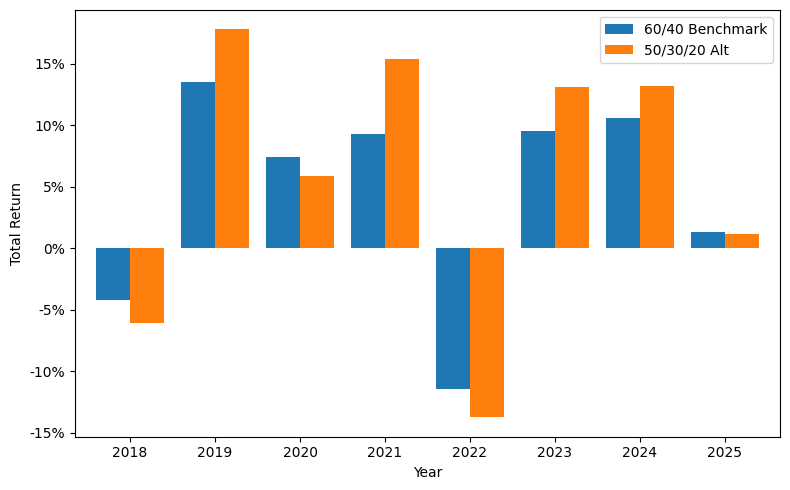

In [ ]:
#One year walkforward testing (With Monthly data)
def one_year_metrics(r, periods_per_year=12, rf=0.03):
    stats = max_drawdown_stats(r)
    return{
        'Total Return': (1+r).prod() -1,
        'annualized_volatility': annualized_volatility(r,periods_per_year),
        'Sharpe': sharpe_ratio(r, periods_per_year, rf),
        'Max DD':         stats['depth'],
        'Sortino': sortino_ratio(r, periods_per_year, rf),
        'DD Duration (m)': stats['duration'],
        'DD Start':       stats['start'].strftime('%Y-%m') if stats['start'] else None,
        'DD Trough':      stats['trough'].strftime('%Y-%m') if stats['trough'] else None
    }
#Dataframe of one-year
rows = []
for year, grp in ports.groupby(ports.index.year):
    bench = grp['60/40 Benchmark']
    alt   = grp['50/30/20 Alt']
    bench_m = one_year_metrics(bench)
    alt_m   = one_year_metrics(alt)
    #Added active return and tracking error
    active = alt - bench
    alt_m['Active Return (annualized)'] = active.mean()* 12
    alt_m['Tracking Error (annualized)'] = active.std()* np.sqrt(12)
    # flatten into one row
    row = {'Year': year}
    for k, v in bench_m.items():
        row[f'Bench {k}'] = v
    for k, v in alt_m.items():
        row[f'Alt {k}'] = v
    rows.append(row)

metrics_by_year = pd.DataFrame(rows).set_index('Year').sort_index()
print(metrics_by_year)

#Optional: save into an excel file
with pd.ExcelWriter('Yearly Metrics Comparison2.xlsx') as writer:
    metrics_by_year.to_excel(writer, sheet_name= 'Metrics', index = False)
print('Excel file has been created')

#Plot
yearly_ret = metrics_by_year[['Bench Total Return', 'Alt Total Return']]

ax = yearly_ret.plot(
    kind = 'bar',
    figsize=(8,5),
    width = 0.8
)
#ax.set_title('Annual Total Returns: 60/40 vs 50/30/20')
ax.set_xlabel('Year')
ax.set_ylabel('Total Return')
ax.legend(['60/40 Benchmark','50/30/20 Alt'])
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

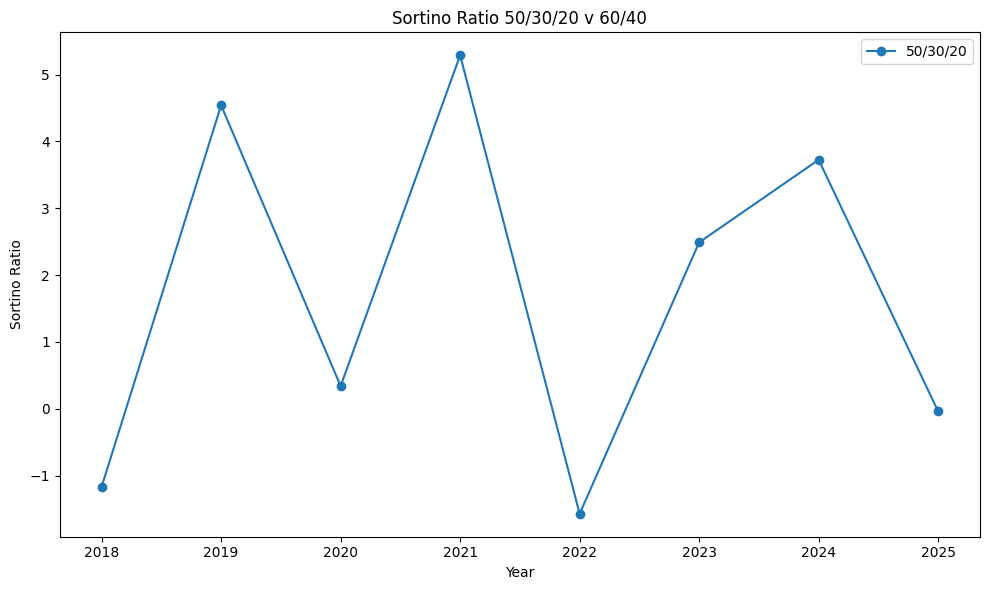

Date
2018-01-01         NaN
2018-02-01         NaN
2018-03-01         NaN
2018-04-01         NaN
2018-05-01         NaN
                ...   
2025-03-01    0.079895
2025-04-01    0.171714
2025-05-01    0.393694
2025-06-01    0.840543
2025-07-01    0.669758
Name: 50/30/20 Alt, Length: 91, dtype: float64


In [ ]:
#Visualizing individual metrics
yearly_Sortino = metrics_by_year[['Alt Sortino']]

ax = yearly_Sortino.plot(
    marker='o',
    figsize=(10,6)
)
ax.set_title('Sortino Ratio 50/30/20 v 60/40')
ax.set_xlabel('Year')
ax.set_ylabel('Sortino Ratio')
ax.legend(['50/30/20'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

rolling_sortino = (
    (ports['50/30/20 Alt'] - 0.03/12).rolling(36).mean() * 12 /
    (np.sqrt(((ports['50/30/20 Alt'] - 0.03/12)
             .where(lambda x: x<0, 0)**2).rolling(36).mean()) * np.sqrt(12))
)
print(rolling_sortino)

# Bootstrapping

                                        p2.5       p50     p97.5
Series Metrics                                                  
Alt    Max Drawdown                -0.352356 -0.170045 -0.082642
       Sharpe                      -0.396830  0.276655  1.046313
       Sortino                     -0.479462  0.394572  1.824746
       Total Return                -0.141589  0.494318  1.561418
Bench  Max Drawdown                -0.276449 -0.131191 -0.065127
       Sharpe                      -0.477868  0.194913  0.943836
       Sortino                     -0.592411  0.274763  1.570697
       Total Return                -0.087718  0.375074  1.064940
Pair   Active Return (annualized)  -0.008666  0.012982  0.034042
       Information Ratio v 60/40   -0.259706  0.444188  1.313931
       Tracking Error (annualized)  0.023427  0.029159  0.037222


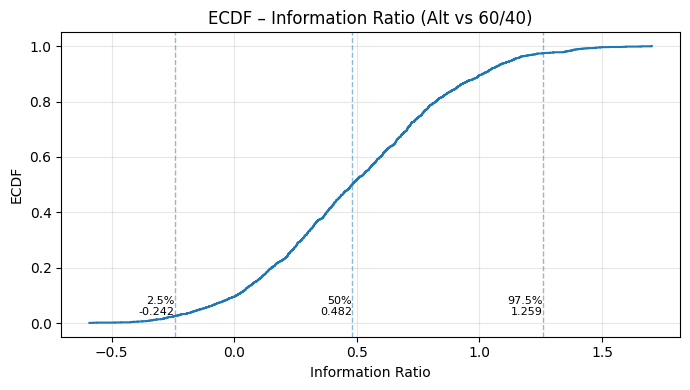

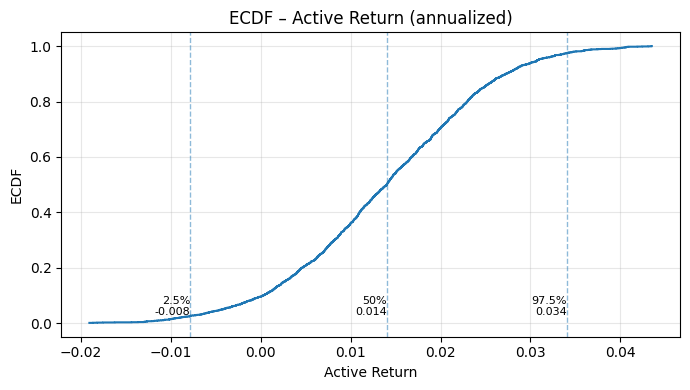

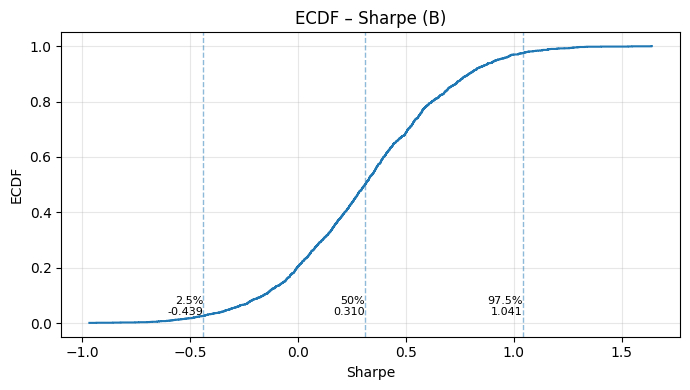

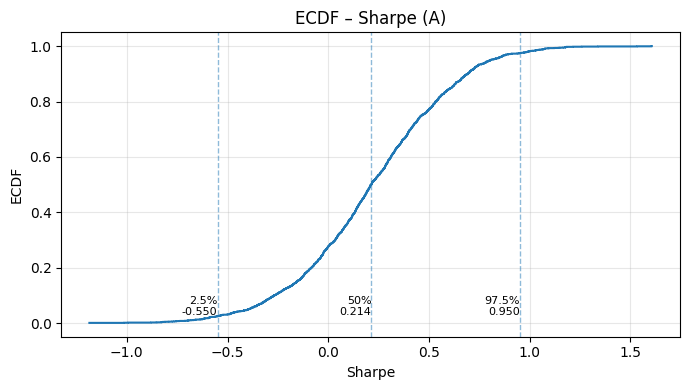

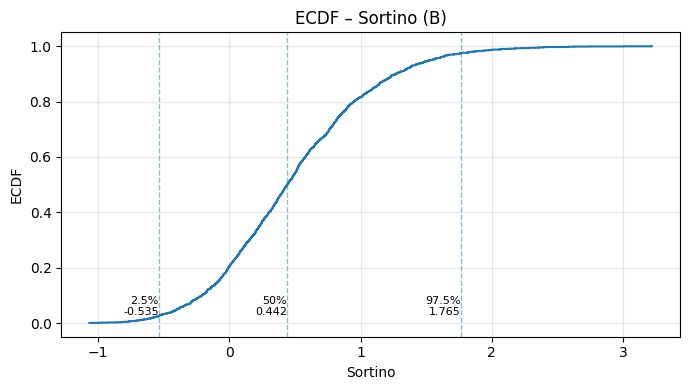

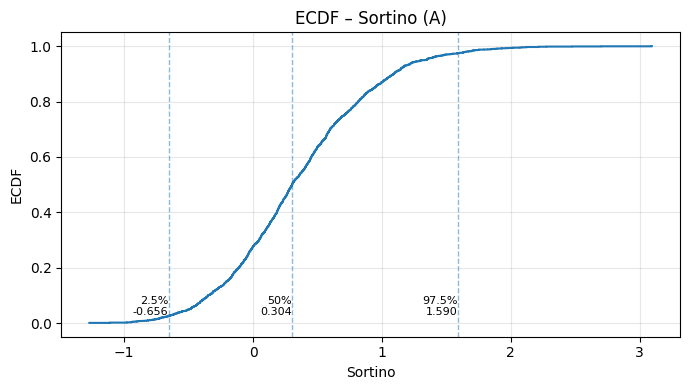

In [20]:
#GENERALIZED BOOTSTRAPPING TEMPLATE (Functions)

def bootstrap_metrics(series_dict,
                     single_metrics,
                     pair_metrics = None,
                     n_boot = 2000,
                     seed = 420,
                     resample = 'iid', # or block is auto-correl suspected
                     block_len = None, # if resample = block, then required, integer
                     return_draws= False): #Change for ECDF
    rng = np.random.default_rng(seed)
    #Convert the series to aligned numpy array
    df = pd.DataFrame(series_dict).dropna()
    n = len(df)

    #Draw sample indices function
    def draw_indices():
        if resample == 'iid':
            return rng.integers(0, n, n)
        elif resample == 'block':
            if block_len is None:
                raise ValueError('Specify Block Length for block boostrap (integer)')
            starts = rng.integers(0, n - block_len + 1, int(np.ceil(n/block_len)))
            idx = np.concatenate([np.arange(s, s+block_len) for s in starts])[:n]
            return idx
        else:
            raise ValueError('resample must be iid or block bruv')
        
    #Storing
    results = {name: {m: [] for m in single_metrics} for name in series_dict}
    pair_results = {m: [] for m in (pair_metrics or {})}

    #Boostrapping loop
    for _ in range(n_boot):
        idx = draw_indices()
        sample = df.iloc[idx]

        #Single metrics
        for name in series_dict:
            s = sample[name]
            for m_name, fn in single_metrics.items():
                results[name][m_name].append(fn(s))

        #Pair metrics
        if pair_metrics:
            keys = list(series_dict.keys())
            a,b = sample[keys[0]], sample[keys[1]] # Change the 0,1 if want to compare different metrics
            for m_name, fn in pair_metrics.items():
                pair_results[m_name].append(fn(a,b))

    #DataFrame of Confidence Interval
    def summarize(lst):
        arr = np.asarray(lst, dtype=float)
        pct = np.nanpercentile  # use np.percentile if you know there are no NaNs
        p2_5, p50, p97_5 = pct(arr, [2.5, 50, 97.5])
        return pd.Series({'p2.5': p2_5, 'p50': p50, 'p97.5': p97_5})
    
    out_single = []
    for name in results:
        for m_name, vals in results[name].items():
            tmp = summarize(vals)
            tmp.name = (name, m_name)
            out_single.append(tmp)
    single_df = pd.DataFrame(out_single)

    if pair_metrics:
        out_pair = []
        for m_name, vals in pair_results.items():
            tmp = summarize(vals)
            tmp.name = ('Pair', m_name)
            out_pair.append(tmp)
        pair_df = pd.DataFrame(out_pair)
        out = pd.concat([single_df, pair_df])
    else:
        out = single_df

    out.index = pd.MultiIndex.from_tuples(out.index, names = ['Series', 'Metrics'])
    return (out.sort_index(), results, pair_results) if return_draws else out.sort_index()

#Helper for max drawdown
def max_drawdown_np(r):
    arr = (1 + r).values
    cum = np.cumprod(arr)
    peak = np.maximum.accumulate(cum)
    dd   = cum/peak - 1
    return float(dd.min())

#Bootstrap

# series_dict: order matters if pair_metrics expect Alt vs Bench
series_dict = {
    'Alt':   ports['50/30/20 Alt'],
    'Bench': ports['60/40 Benchmark']
}

single_metrics = {
    
    #'CAGR':            lambda r: cagr(r),
    'Sharpe':          lambda r: sharpe_ratio(r, rf=0.03),
    'Sortino':         lambda r: sortino_ratio(r, rf=0.03),
    #'Volatility':      lambda r: annualized_volatility(r),
    'Max Drawdown':    max_drawdown_np,
    'Total Return':    lambda r: (1+r).prod() - 1
}

pair_metrics = {
    'Information Ratio v 60/40': lambda a, b: information_ratio(a, b),
    'Active Return (annualized)': lambda a, b: (a - b).mean()*12,
    'Tracking Error (annualized)': lambda a, b: (a - b).std()*np.sqrt(12)
}

boot_summary = bootstrap_metrics(series_dict,
                                 single_metrics,
                                 pair_metrics,
                                 n_boot=2000,
                                 seed=420)

print(boot_summary)

#ECDF Plot
boot_summary, single_draws, pair_draws = bootstrap_metrics(
    series_dict, single_metrics, pair_metrics,
    n_boot=2000, seed=123, return_draws=True)

ir_draws = pair_draws['Information Ratio v 60/40'] # Change this to whatever variable you want

def plot_ecdf(samples, title='ECDF', xlabel='Value', pct_levels=(2.5, 50, 97.5)):
    x = np.sort(np.asarray(samples))
    y = np.arange(1, x.size + 1) / x.size

    fig, ax = plt.subplots(figsize=(7,4))
    ax.step(x, y, where='post')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('ECDF')
    ax.grid(alpha=0.3)

    # percentiles
    qs = np.percentile(x, pct_levels)
    for q, v in zip(pct_levels, qs):
        ax.axvline(v, ls='--', lw=1, alpha=0.5)
        ax.text(v, 0.02, f'{q}%\n{v:.3f}', rotation=0,
                va='bottom', ha='right', fontsize=8) #Vertical and Horizontal alignment

    plt.tight_layout()
    plt.show()

to_plot = {
    'Information Ratio (Alt vs 60/40)': pair_draws['Information Ratio v 60/40'],
    'Active Return (annualized)': pair_draws['Active Return (annualized)'],
    'Sharpe (B)':                     single_draws['Alt']['Sharpe'],
    'Sharpe (A)':                   single_draws['Bench']['Sharpe'],
    'Sortino (B)':                    single_draws['Alt']['Sortino'],
    'Sortino (A)':                  single_draws['Bench']['Sortino'],
}

# plot
for label, samples in to_plot.items():
    plot_ecdf(samples, title=f'ECDF – {label}', xlabel=label.split('(')[0].strip())

                                        p2.5       p50     p97.5
Series Metrics                                                  
Alt    Max Drawdown                -0.318168 -0.166447 -0.092171
       Sharpe                      -0.302864  0.283312  0.982480
       Sortino                     -0.382290  0.399984  1.654516
       Total Return                -0.060348  0.498598  1.405919
Bench  Max Drawdown                -0.237357 -0.123644 -0.066894
       Sharpe                      -0.385453  0.203648  0.880266
       Sortino                     -0.484303  0.284529  1.477495
       Total Return                -0.032523  0.386312  0.994454
Pair   Active Return (annualized)  -0.007193  0.013077  0.031247
       Information Ratio v 60/40   -0.208218  0.444114  1.219750
       Tracking Error (annualized)  0.023140  0.029423  0.037149


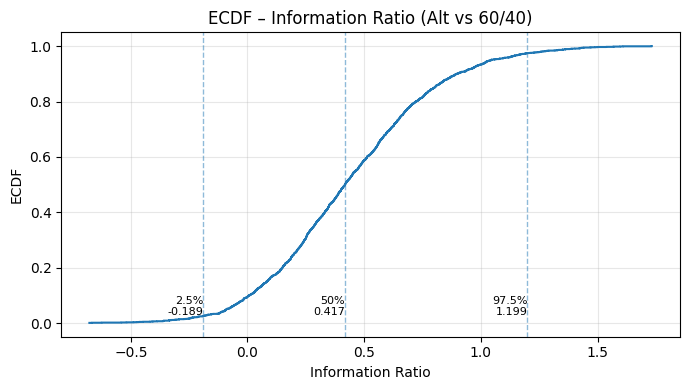

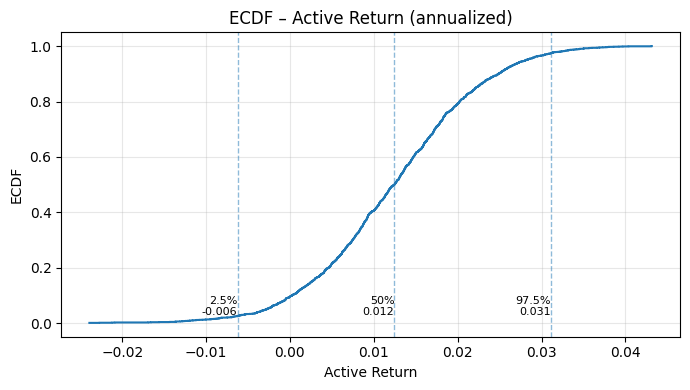

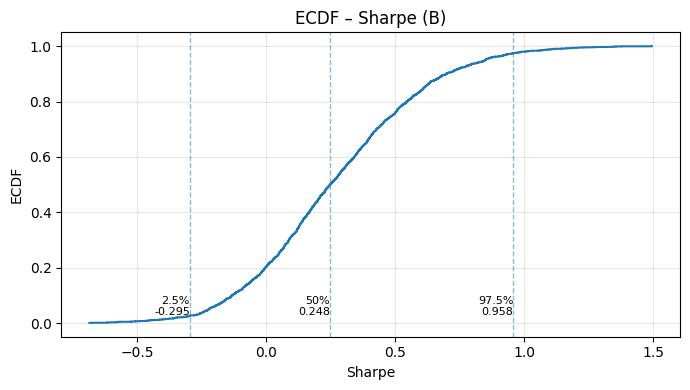

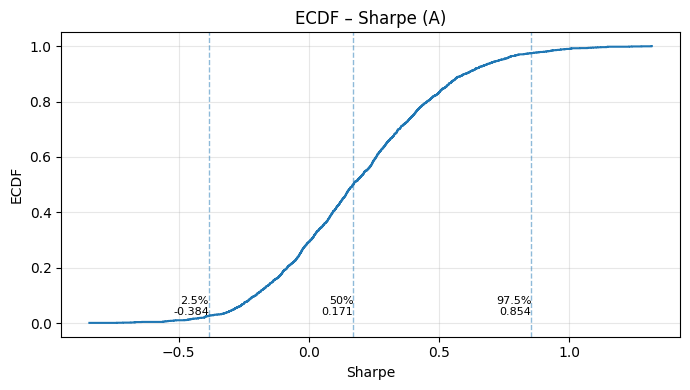

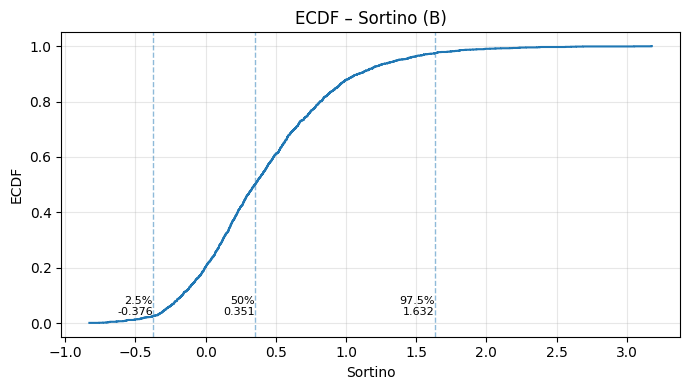

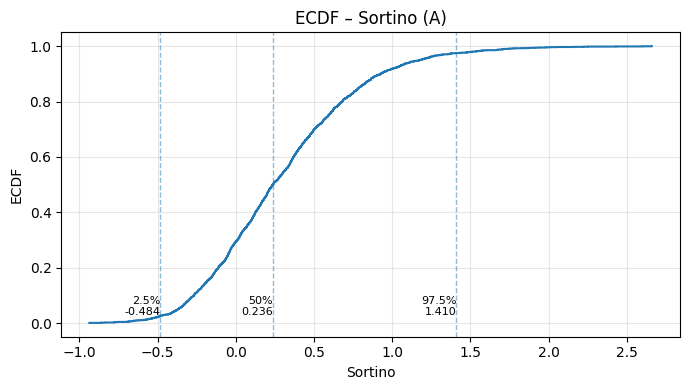

In [24]:
#GENERALIZED BOOTSTRAPPING TEMPLATE (Functions) (Block)

def bootstrap_metrics(series_dict,
                     single_metrics,
                     pair_metrics = None,
                     n_boot = 2000,
                     seed = 420,
                     resample = 'block', # or block is auto-correl suspected
                     block_len = 5, # if resample = block, then required, integer
                     return_draws= False): #Change for ECDF
    rng = np.random.default_rng(seed)
    #Convert the series to aligned numpy array
    df = pd.DataFrame(series_dict).dropna()
    n = len(df)

    #Draw sample indices function
    def draw_indices():
        if resample == 'iid':
            return rng.integers(0, n, n)
        elif resample == 'block':
            if block_len is None:
                raise ValueError('Specify Block Length for block boostrap (integer)')
            starts = rng.integers(0, n - block_len + 1, int(np.ceil(n/block_len)))
            idx = np.concatenate([np.arange(s, s+block_len) for s in starts])[:n]
            return idx
        else:
            raise ValueError('resample must be iid or block bruv')
        
    #Storing
    results = {name: {m: [] for m in single_metrics} for name in series_dict}
    pair_results = {m: [] for m in (pair_metrics or {})}

    #Boostrapping loop
    for _ in range(n_boot):
        idx = draw_indices()
        sample = df.iloc[idx]

        #Single metrics
        for name in series_dict:
            s = sample[name]
            for m_name, fn in single_metrics.items():
                results[name][m_name].append(fn(s))

        #Pair metrics
        if pair_metrics:
            keys = list(series_dict.keys())
            a,b = sample[keys[0]], sample[keys[1]] # Change the 0,1 if want to compare different metrics
            for m_name, fn in pair_metrics.items():
                pair_results[m_name].append(fn(a,b))

    #DataFrame of Confidence Interval
    def summarize(lst):
        arr = np.asarray(lst, dtype=float)
        pct = np.nanpercentile  # use np.percentile if you know there are no NaNs
        p2_5, p50, p97_5 = pct(arr, [2.5, 50, 97.5])
        return pd.Series({'p2.5': p2_5, 'p50': p50, 'p97.5': p97_5})
    
    out_single = []
    for name in results:
        for m_name, vals in results[name].items():
            tmp = summarize(vals)
            tmp.name = (name, m_name)
            out_single.append(tmp)
    single_df = pd.DataFrame(out_single)

    if pair_metrics:
        out_pair = []
        for m_name, vals in pair_results.items():
            tmp = summarize(vals)
            tmp.name = ('Pair', m_name)
            out_pair.append(tmp)
        pair_df = pd.DataFrame(out_pair)
        out = pd.concat([single_df, pair_df])
    else:
        out = single_df

    out.index = pd.MultiIndex.from_tuples(out.index, names = ['Series', 'Metrics'])
    return (out.sort_index(), results, pair_results) if return_draws else out.sort_index()

#Helper for max drawdown
def max_drawdown_np(r):
    arr = (1 + r).values
    cum = np.cumprod(arr)
    peak = np.maximum.accumulate(cum)
    dd   = cum/peak - 1
    return float(dd.min())

#Bootstrap

# series_dict: order matters if pair_metrics expect Alt vs Bench
series_dict = {
    'Alt':   ports['50/30/20 Alt'],
    'Bench': ports['60/40 Benchmark']
}

single_metrics = {
    
    #'CAGR':            lambda r: cagr(r),
    'Sharpe':          lambda r: sharpe_ratio(r, rf=0.03),
    'Sortino':         lambda r: sortino_ratio(r, rf=0.03),
    #'Volatility':      lambda r: annualized_volatility(r),
    'Max Drawdown':    max_drawdown_np,
    'Total Return':    lambda r: (1+r).prod() - 1
}

pair_metrics = {
    'Information Ratio v 60/40': lambda a, b: information_ratio(a, b),
    'Active Return (annualized)': lambda a, b: (a - b).mean()*12,
    'Tracking Error (annualized)': lambda a, b: (a - b).std()*np.sqrt(12)
}

boot_summary = bootstrap_metrics(series_dict,
                                 single_metrics,
                                 pair_metrics,
                                 n_boot=2000,
                                 seed=420)

print(boot_summary)

#ECDF Plot
boot_summary, single_draws, pair_draws = bootstrap_metrics(
    series_dict, single_metrics, pair_metrics,
    n_boot=2000, seed=123, return_draws=True)

ir_draws = pair_draws['Information Ratio v 60/40'] # Change this to whatever variable you want

def plot_ecdf(samples, title='ECDF', xlabel='Value', pct_levels=(2.5, 50, 97.5)):
    x = np.sort(np.asarray(samples))
    y = np.arange(1, x.size + 1) / x.size

    fig, ax = plt.subplots(figsize=(7,4))
    ax.step(x, y, where='post')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('ECDF')
    ax.grid(alpha=0.3)

    # percentiles
    qs = np.percentile(x, pct_levels)
    for q, v in zip(pct_levels, qs):
        ax.axvline(v, ls='--', lw=1, alpha=0.5)
        ax.text(v, 0.02, f'{q}%\n{v:.3f}', rotation=0,
                va='bottom', ha='right', fontsize=8) #Vertical and Horizontal alignment

    plt.tight_layout()
    plt.show()

to_plot = {
    'Information Ratio (Alt vs 60/40)': pair_draws['Information Ratio v 60/40'],
    'Active Return (annualized)': pair_draws['Active Return (annualized)'],
    'Sharpe (B)':                     single_draws['Alt']['Sharpe'],
    'Sharpe (A)':                   single_draws['Bench']['Sharpe'],
    'Sortino (B)':                    single_draws['Alt']['Sortino'],
    'Sortino (A)':                  single_draws['Bench']['Sortino'],
}

# plot
for label, samples in to_plot.items():
    plot_ecdf(samples, title=f'ECDF – {label}', xlabel=label.split('(')[0].strip())